In [1]:
# Loading in libraries necessary for CNN
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import time

# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")


Using cuda device


In [2]:
files = glob.glob('./Spectral_Data/spectral_data/1200MHz/*.csv')
print('Total number of files: ', len(files))

Total number of files:  10354


Establishing a Dataloader for 1200MHz dataset

In [10]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading
        self.df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('./Spectral_Data/spectral_data/1200MHz', 
                                                       'spectral_data_*.csv'))),ignore_index=True)
       
        self.df = self.df.drop(self.df.columns[0], axis=1).to_numpy()
        self.x = torch.from_numpy(self.df[:,:2]).float().to(device)
        self.y = torch.from_numpy(self.df[:,2:4]).float().to(device)
        self.num_samples = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.num_samples
    
  

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2,5) # input layer to hidden
        self.relu = nn.ReLU() # activation function
        self.fc2 = nn.Linear(5,2) # input layer to output
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [12]:
model = NeuralNetwork().to(device)

In [13]:
# Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.x, dataset.y,
                                                    test_size=0.2)

# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

KeyboardInterrupt: 

In [ ]:
# Moving to device if CUDA is available
#train_dataloader = train_dataloader.to(device)
#test_dataloader = test_dataloader.to(device)

print(train_dataloader)
print(test_dataset)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = SGD(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 3

In [ ]:
# Training loop for model with epoch loss as output

x = time.time()

for e in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    
    if(int(e) % 10) == 0:
        
        print(f'Epoch {e+1} loss: {epoch_loss:.4f}')

print(f'Time Elapsed: {round(time.time()-x, 5)} seconds')    

In [ ]:
# Evaluating Model Performance

model.eval() # Model to evaluation mode

total_loss = 0.0
total_correct = 0

# Loop for testing
for inputs, labels in test_dataloader:
    #Forward pass
    outputs = model(inputs)
    total_loss += loss.item() * inputs.size(0)
    
    _, labels = torch.max(labels,1)
    _, predicts = torch.max(outputs.data, 1)
    total_correct += (predicts == labels).sum().item()

mean_loss = total_loss / len(test_dataset)
accuracy = (total_correct / len(test_dataset))*100



In [62]:
print(f' Mean Loss of Function: {mean_loss}, Accuracy: {accuracy}')

 Mean Loss of Function: 0.0032838843762874603, Accuracy: 95.16818181818182


In [63]:
model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        predictions = model(inputs)

predictions_numpy = predictions.cpu().numpy()
pred = pd.DataFrame(predictions_numpy)

In [69]:
df_60 = pd.read_csv('./Spectral_Data/spectral_data/1200MHz/spectral_data_05_00033.csv')
df_x = df_60[['1200MHz_ppm', '1200MHz_intensity']]
df_x = df_x.to_numpy()
df_x = torch.Tensor(df_x).to(device)
df_x

tensor([[-5.0000e-01,  5.0913e-07],
        [-4.9800e-01,  5.1214e-07],
        [-4.9600e-01,  5.1518e-07],
        ...,
        [ 1.0496e+01,  9.5154e-08],
        [ 1.0498e+01,  9.5067e-08],
        [ 1.0500e+01,  9.4980e-08]], device='cuda:0')

In [70]:
predictions = model(df_x)
predictions_numpy = predictions.detach().cpu().numpy()

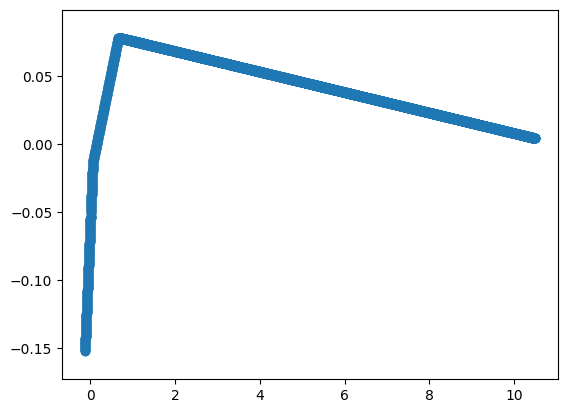

In [71]:
x = predictions_numpy[:, 0]
y = predictions_numpy[:, 1]

fig = plt.scatter(x,y)

In [15]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

In [7]:
test = glob.glob(os.path.join('./Spectral_Data/spectral_data/1200MHz', 
                                                       'spectral_data_*.csv'))

y_60 = []
y_1200 = []

for file in test:
    df = pd.read_csv(file)
    array_60 = df['60MHz_intensity'].to_numpy()
    array_1200 = df['1200MHz_intensity'].to_numpy()
    y_60.append(array_60)
    y_1200.append(array_1200)

tensor = torch.FloatTensor(y_60)
tensor
    

/home/garrettreinhard/miniconda3/envs/isotope/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  


tensor([[1.7944e-04, 1.8058e-04, 1.8174e-04,  ..., 1.7502e-04, 1.7472e-04,
         1.7443e-04],
        [2.9429e-04, 2.9571e-04, 2.9715e-04,  ..., 1.9060e-04, 1.9026e-04,
         1.8992e-04],
        [2.8279e-04, 2.8431e-04, 2.8585e-04,  ..., 4.7641e-05, 4.7574e-05,
         4.7508e-05],
        ...,
        [5.1728e-04, 5.1939e-04, 5.2152e-04,  ..., 1.0432e-04, 1.0419e-04,
         1.0407e-04],
        [3.9843e-04, 4.0017e-04, 4.0193e-04,  ..., 2.6069e-04, 2.6021e-04,
         2.5972e-04],
        [3.0034e-04, 3.0170e-04, 3.0308e-04,  ..., 1.0290e-04, 1.0280e-04,
         1.0269e-04]])